# 导包

In [37]:
import numpy as np

# 初始化邻接矩阵

In [38]:
inf = np.inf  # np.inf就代表无穷大
mtx_graph = [[0, 1, inf, 3, inf, inf, inf, inf, inf],
             [1, 0, 5, inf, 2, inf, inf, inf, inf],
             [inf, inf, 0, 1, inf, 6, inf, inf, inf],
             [inf, inf, inf, 0, inf, 7, inf, 9, inf],
             [inf, 2, 3, inf, 0, 4, 2, inf, 8],
             [inf, inf, 6, 7, inf, 0, inf, 2, inf],
             [inf, inf, inf, inf, inf, 1, 0, inf, 3],
             [inf, inf, inf, inf, inf, inf, 1, 0, 2],
             [inf, inf, inf, inf, 8, inf, inf, 2, 0]]

In [53]:
A = np.array(mtx_graph)  # 邻接矩阵转化为ndarray矩阵, 形式没有变, 只是改了数据类型
A

array([[ 0.,  1., inf,  3., inf, inf, inf, inf, inf],
       [ 1.,  0.,  5., inf,  2., inf, inf, inf, inf],
       [inf, inf,  0.,  1., inf,  6., inf, inf, inf],
       [inf, inf, inf,  0., inf,  7., inf,  9., inf],
       [inf,  2.,  3., inf,  0.,  4.,  2., inf,  8.],
       [inf, inf,  6.,  7., inf,  0., inf,  2., inf],
       [inf, inf, inf, inf, inf,  1.,  0., inf,  3.],
       [inf, inf, inf, inf, inf, inf,  1.,  0.,  2.],
       [inf, inf, inf, inf,  8., inf, inf,  2.,  0.]])

In [55]:
A * 3

array([[ 0.,  3., inf,  9., inf, inf, inf, inf, inf],
       [ 3.,  0., 15., inf,  6., inf, inf, inf, inf],
       [inf, inf,  0.,  3., inf, 18., inf, inf, inf],
       [inf, inf, inf,  0., inf, 21., inf, 27., inf],
       [inf,  6.,  9., inf,  0., 12.,  6., inf, 24.],
       [inf, inf, 18., 21., inf,  0., inf,  6., inf],
       [inf, inf, inf, inf, inf,  3.,  0., inf,  9.],
       [inf, inf, inf, inf, inf, inf,  3.,  0.,  6.],
       [inf, inf, inf, inf, 24., inf, inf,  6.,  0.]])

In [ ]:
print(A.shape)  # 输出矩阵大小 -> (9, 9)

In [40]:
A

array([[ 0.,  1., inf,  3., inf, inf, inf, inf, inf],
       [ 1.,  0.,  5., inf,  2., inf, inf, inf, inf],
       [inf, inf,  0.,  1., inf,  6., inf, inf, inf],
       [inf, inf, inf,  0., inf,  7., inf,  9., inf],
       [inf,  2.,  3., inf,  0.,  4.,  2., inf,  8.],
       [inf, inf,  6.,  7., inf,  0., inf,  2., inf],
       [inf, inf, inf, inf, inf,  1.,  0., inf,  3.],
       [inf, inf, inf, inf, inf, inf,  1.,  0.,  2.],
       [inf, inf, inf, inf,  8., inf, inf,  2.,  0.]])

In [41]:
N = A.shape[0]  # 矩阵长度 N = 9

# 初始化路径矩阵

In [42]:
# 维护一个路径矩阵，刚开始都是0, 表示从一个点到另一个点途径哪个点路径最短
path = np.zeros((N, N))

In [43]:
path

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [44]:
# i和j分别代表行索引和列索引, 所以嵌套两个循环, 就可以遍历矩阵中每一个点
# A是邻接矩阵, 通过A[i][j]遍历所有的点
for i in range(0, N):
    for j in range(0, N):
        if A[i][j] != inf:  
            # 如果在邻接矩阵中, 该点的值不是无穷大, 就直接把途径点写为目标点
            # 否则就不管, 还是保留0
            path[i][j] = j

# 这一步是为了初始化路径矩阵

In [45]:
path

array([[0., 1., 0., 3., 0., 0., 0., 0., 0.],
       [0., 1., 2., 0., 4., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 5., 0., 0., 0.],
       [0., 0., 0., 3., 0., 5., 0., 7., 0.],
       [0., 1., 2., 0., 4., 5., 6., 0., 8.],
       [0., 0., 2., 3., 0., 5., 0., 7., 0.],
       [0., 0., 0., 0., 0., 5., 6., 0., 8.],
       [0., 0., 0., 0., 0., 0., 6., 7., 8.],
       [0., 0., 0., 0., 4., 0., 0., 7., 8.]])

In [46]:
path[1][2]

2.0

# 循环遍历更新

In [47]:
'''
更新的时候，比如i行，j列，在邻接矩阵A中表示从编号i到编号j的距离， A[i][j]
在路径矩阵path中表示从编号i到编号j途经哪个点最近，k就是遍历所有点，找到最近的途径点 path[i][j]

比如从1到2（就是i到j），直接去的话，路程是10（A[1][2]=10）
但是1到3的路程是4，3到2的路程是1，所以有 A[1][3]=4，A[3][2]=1，

【条件判断】  这样就有A[1][3] + A[3][2] < A[1][2]成立，于是就把A[1][2]=5更新为
【更新A[i][j]】  A[1][2] = d[1][3] + A[3][2]

路径矩阵从1到2原本是path[1][2]=2，表示直接从1到2，但是现在发现1->3->2更近

【更新path[i][j]】 所以path[1][2]=2就改成path[1][2]=3，表示从1到2途经3是最近的 

可能后来发现1->5->2是最近的，也会更新掉1->3->2的方案
因为中间点k是从1到9全部遍历的，所以都会对比一下
只要有更小的，就更新A和path的信息

这就是下面这个循环的意思
'''


for k in range(0, N):  # N=9. 所以这里是[0, 9)，实际上是0~8
    for i in range(0, N):
        for j in range(0, N):
            if A[i][k] + A[k][j] < A[i][j]:  # 【条件判断】
                A[i][j] = A[i][k] + A[k][j]  # 【更新A[i][j]】
                path[i][j] = path[i][k]  # 【更新path[i][j]】

In [48]:
list(range(9))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [50]:
path

array([[0., 1., 1., 3., 1., 1., 1., 1., 1.],
       [0., 1., 2., 0., 4., 4., 4., 4., 4.],
       [5., 5., 2., 3., 5., 5., 5., 5., 5.],
       [7., 7., 5., 3., 7., 5., 7., 7., 7.],
       [1., 1., 2., 2., 4., 6., 6., 6., 6.],
       [7., 7., 2., 3., 7., 5., 7., 7., 7.],
       [8., 8., 5., 5., 8., 5., 6., 5., 8.],
       [8., 8., 6., 6., 8., 6., 6., 7., 8.],
       [4., 4., 7., 7., 4., 7., 7., 7., 8.]])

In [51]:
path + 1  # 可以得出和下面的代码一样的结果，这个更简单

array([[1., 2., 2., 4., 2., 2., 2., 2., 2.],
       [1., 2., 3., 1., 5., 5., 5., 5., 5.],
       [6., 6., 3., 4., 6., 6., 6., 6., 6.],
       [8., 8., 6., 4., 8., 6., 8., 8., 8.],
       [2., 2., 3., 3., 5., 7., 7., 7., 7.],
       [8., 8., 3., 4., 8., 6., 8., 8., 8.],
       [9., 9., 6., 6., 9., 6., 7., 6., 9.],
       [9., 9., 7., 7., 9., 7., 7., 8., 9.],
       [5., 5., 8., 8., 5., 8., 8., 8., 9.]])

In [34]:
# 这里就是遍历所有点，把路径加1，因为python默认是从0开始算的，但是节点是从1开始算的，所以都加1
for i in range(0, N):
    for j in range(0, N):
        path[i][j] = path[i][j] + 1

In [35]:
path

array([[1., 2., 2., 4., 2., 2., 2., 2., 2.],
       [1., 2., 3., 1., 5., 5., 5., 5., 5.],
       [6., 6., 3., 4., 6., 6., 6., 6., 6.],
       [8., 8., 6., 4., 8., 6., 8., 8., 8.],
       [2., 2., 3., 3., 5., 7., 7., 7., 7.],
       [8., 8., 3., 4., 8., 6., 8., 8., 8.],
       [9., 9., 6., 6., 9., 6., 7., 6., 9.],
       [9., 9., 7., 7., 9., 7., 7., 8., 9.],
       [5., 5., 8., 8., 5., 8., 8., 8., 9.]])

In [36]:
print('A = ')
print(A)
print('path = ')
print(path)

A = 
[[ 0.  1.  6.  3.  3.  6.  5.  8.  8.]
 [ 1.  0.  5.  4.  2.  5.  4.  7.  7.]
 [21. 20.  0.  1. 18.  6.  9.  8. 10.]
 [22. 21. 13.  0. 19.  7. 10.  9. 11.]
 [ 3.  2.  3.  4.  0.  3.  2.  5.  5.]
 [15. 14.  6.  7. 12.  0.  3.  2.  4.]
 [14. 13.  7.  8. 11.  1.  0.  3.  3.]
 [13. 12.  8.  9. 10.  2.  1.  0.  2.]
 [11. 10. 10. 11.  8.  4.  3.  2.  0.]]
path = 
[[1. 2. 2. 4. 2. 2. 2. 2. 2.]
 [1. 2. 3. 1. 5. 5. 5. 5. 5.]
 [6. 6. 3. 4. 6. 6. 6. 6. 6.]
 [8. 8. 6. 4. 8. 6. 8. 8. 8.]
 [2. 2. 3. 3. 5. 7. 7. 7. 7.]
 [8. 8. 3. 4. 8. 6. 8. 8. 8.]
 [9. 9. 6. 6. 9. 6. 7. 6. 9.]
 [9. 9. 7. 7. 9. 7. 7. 8. 9.]
 [5. 5. 8. 8. 5. 8. 8. 8. 9.]]


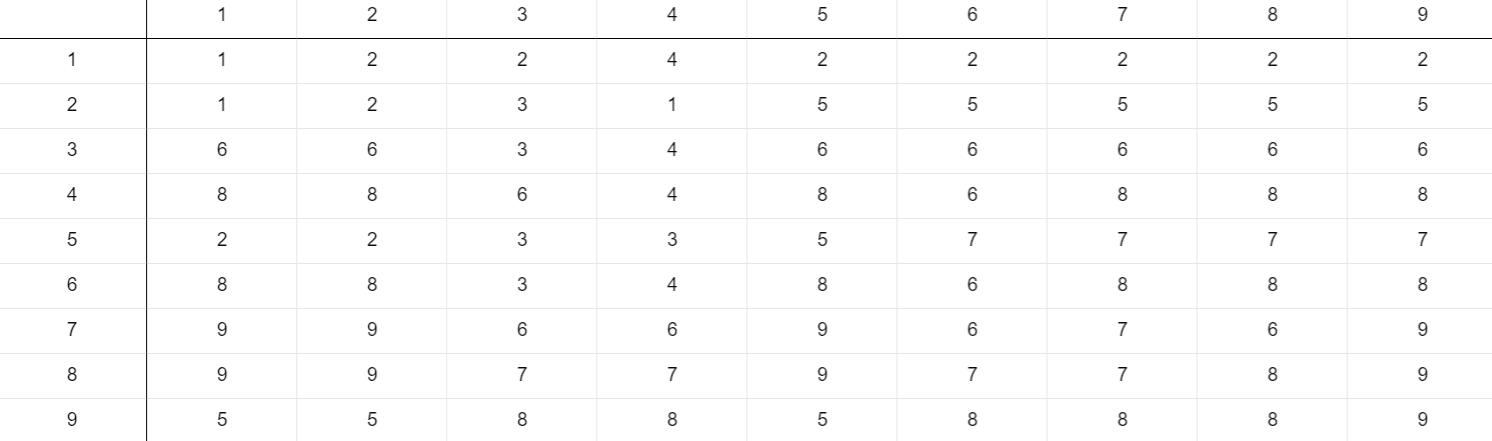

In [ ]:
pycharm 